In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.maze_tree_policy_renderer import render_tree_policy
from mlrl.maze.manhattan_q import ManhattanQHat, InadmissableManhattanQHat

import tensorflow as tf
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

from pathlib import Path
import json
import yaml

/usr/local/lib/python3.10/dist-packages/tf_agents/typing/types.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bool = Union[bool, np.bool, Tensor, Array]


In [2]:
df = pd.DataFrame([
    {
        'name': path.name,
        **json.loads((path / 'files' / 'wandb-summary.json').read_text()),
        **json.loads((path / 'files' / 'wandb-metadata.json').read_text()),
        **{
            k: v['value']
            for k, v in yaml.load((path / 'files' / 'config.yaml').open(), yaml.loader.SafeLoader).items()
            if isinstance(v, dict) and 'value' in v
        },
    }
    for path in Path('wandb').glob('*')
    if path.is_dir() and (path / 'files' / 'wandb-summary.json').exists()
])

In [3]:
from mlrl.experiments.ppo_maze import create_batched_maze_meta_envs, get_maze_name, parse_args
from mlrl.experiments.experiment_utils import create_parser
from mlrl.experiments.ppo_runner import PPORunner

In [4]:
from mlrl.experiments.experiment_utils import create_parser
parser = create_parser()
args = vars(parser.parse_known_args()[0])

In [4]:
env, eval_env, video_env = create_batched_maze_meta_envs(**args)

In [36]:
ppo_runner = PPORunner(
    env, eval_env=eval_env, video_env=video_env,
    name=get_maze_name(args), **args
)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be

In [10]:
policy_path = 'outputs/runs/ppo_run_10-55-23-20-01-2023/10-55-23-20-01-2023/policies/'

In [11]:
# policy = tf.saved_model.load(policy_path + 'collect_policy')
# ts = ppo_runner.eval_env.current_time_step()
# policy.action(ts)

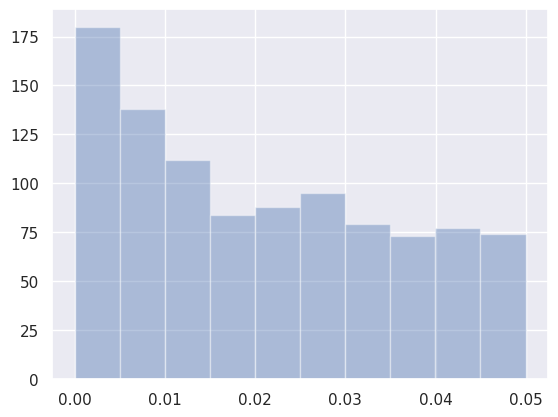

In [22]:
min_cost = 0
max_cost = 0.05

x = (max_cost - min_cost) * np.random.power(0.75, 1000) + min_cost
sns.distplot(x, kde=False)
plt.show()

In [9]:
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.meta.meta_policies.a_star_policy import get_a_star_action

In [11]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(
    AStarPolicy(video_env), video_env, max_steps=60, rewrite_rewards=True))

In [18]:
eval_env.batch_size

32

In [ ]:
from mlrl.experiments.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.experiments.ppo_maze import create_maze_meta_env


a_star_policy = AStarPolicy(eval_env)


evaluator = EvalRunner(
    eval_steps=eval_env.batch_size * 256,
    eval_env=eval_env,
    policy=a_star_policy,
    rewrite_rewards=True,
    use_tf_function=False)

In [9]:
eval_env.batch_size

32

In [10]:
evaluator.run()

3776/8192 [============>.................] - ETA: 5:50 - AverageReturn: 0.6598
Evaluation interrupted.
Evaluation stats:
EvalRewrittenAverageReturn: -0.011, EvalFinalPolicyValue: 0.761, EvalNumberOfEpisodes: 96.000, EvalEnvironmentSteps: 3776.000, EvalAverageReturn: 0.866, EvalAverageEpisodeLength: 30.938, EvalTime: 301.763


{'EvalRewrittenAverageReturn': -0.010764696,
 'EvalFinalPolicyValue': 0.7607889562233184,
 'EvalNumberOfEpisodes': 96,
 'EvalEnvironmentSteps': 3776,
 'EvalAverageReturn': 0.86636084,
 'EvalAverageEpisodeLength': 30.9375,
 'EvalTime': 301.763117313385}

In [4]:
from mlrl.experiments.experiment_utils import create_parser
from mlrl.experiments.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.experiments.ppo_maze import create_maze_meta_env


def compute_metrics_for_costs(make_policy=None, **eval_kwargs):
    costs = [
        0, 0.001, 0.002, 0.004, 0.008, 0.02, 0.05, 0.1
    ]

    make_policy = make_policy or (lambda env: AStarPolicy(env))

    parser = create_parser()
    config = vars(parser.parse_known_args()[0])

    BATCH_SIZE = 4
    STEPS = 150

    config['random_cost_of_computation'] = False
    config['enable_rendering'] = False
    
    if 'seed' in config:
        del config['seed']

    results = []
    for cost in costs:
        print(f'Evaluating with computational cost = {cost}')

        config['cost_of_computation'] = cost
        envs = BatchedPyEnvironment([
            GymWrapper(create_maze_meta_env(seed=seed, **config))
            for seed in range(BATCH_SIZE)
        ], multithreading=True)

        evaluator = EvalRunner(
            eval_steps=envs.batch_size * STEPS,
            eval_env=envs,
            policy=make_policy(envs),
            rewrite_rewards=True,
            **eval_kwargs)
        
        results.append({'CostOfComputation': cost, **evaluator.run()})
    
    return results

In [5]:
parser = create_parser()
config = vars(parser.parse_known_args()[0])
if 'seed' in config:
    del config['seed']
    
envs = BatchedPyEnvironment([
    GymWrapper(create_maze_meta_env(seed=seed, **config))
    for seed in range(4)
], multithreading=True)


In [9]:
a_star_results = compute_metrics_for_costs(convert_to_eager=True, use_tf_function=False)

Evaluating with computational cost = 0
600/600 [==============================] - 43s 72ms/step - AverageReturn: 1.2136
Evaluation stats:
EvalRewrittenAverageReturn: 0.797, EvalFinalPolicyValue: 0.793, EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 600.000, EvalAverageReturn: 1.414, EvalAverageEpisodeLength: 30.375, EvalTime: 42.967
Evaluating with computational cost = 0.001
600/600 [==============================] - 43s 72ms/step - AverageReturn: 1.2007
Evaluation stats:
EvalRewrittenAverageReturn: 0.767, EvalFinalPolicyValue: 0.793, EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 600.000, EvalAverageReturn: 1.384, EvalAverageEpisodeLength: 30.375, EvalTime: 43.242
Evaluating with computational cost = 0.002
600/600 [==============================] - 43s 72ms/step - AverageReturn: 1.1662
Evaluation stats:
EvalRewrittenAverageReturn: 0.736, EvalFinalPolicyValue: 0.793, EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 600.000, EvalAverageReturn: 1.355, EvalAverageEpisodeLengt

In [14]:
a_star_results_df = pd.DataFrame(a_star_results)

In [6]:
meta_env = env.envs[0].gym.env

In [17]:
meta_env.reset()
meta_env.step(1);
meta_env.step(2);
print(meta_env.cost_of_computation)

0.027936951265040477


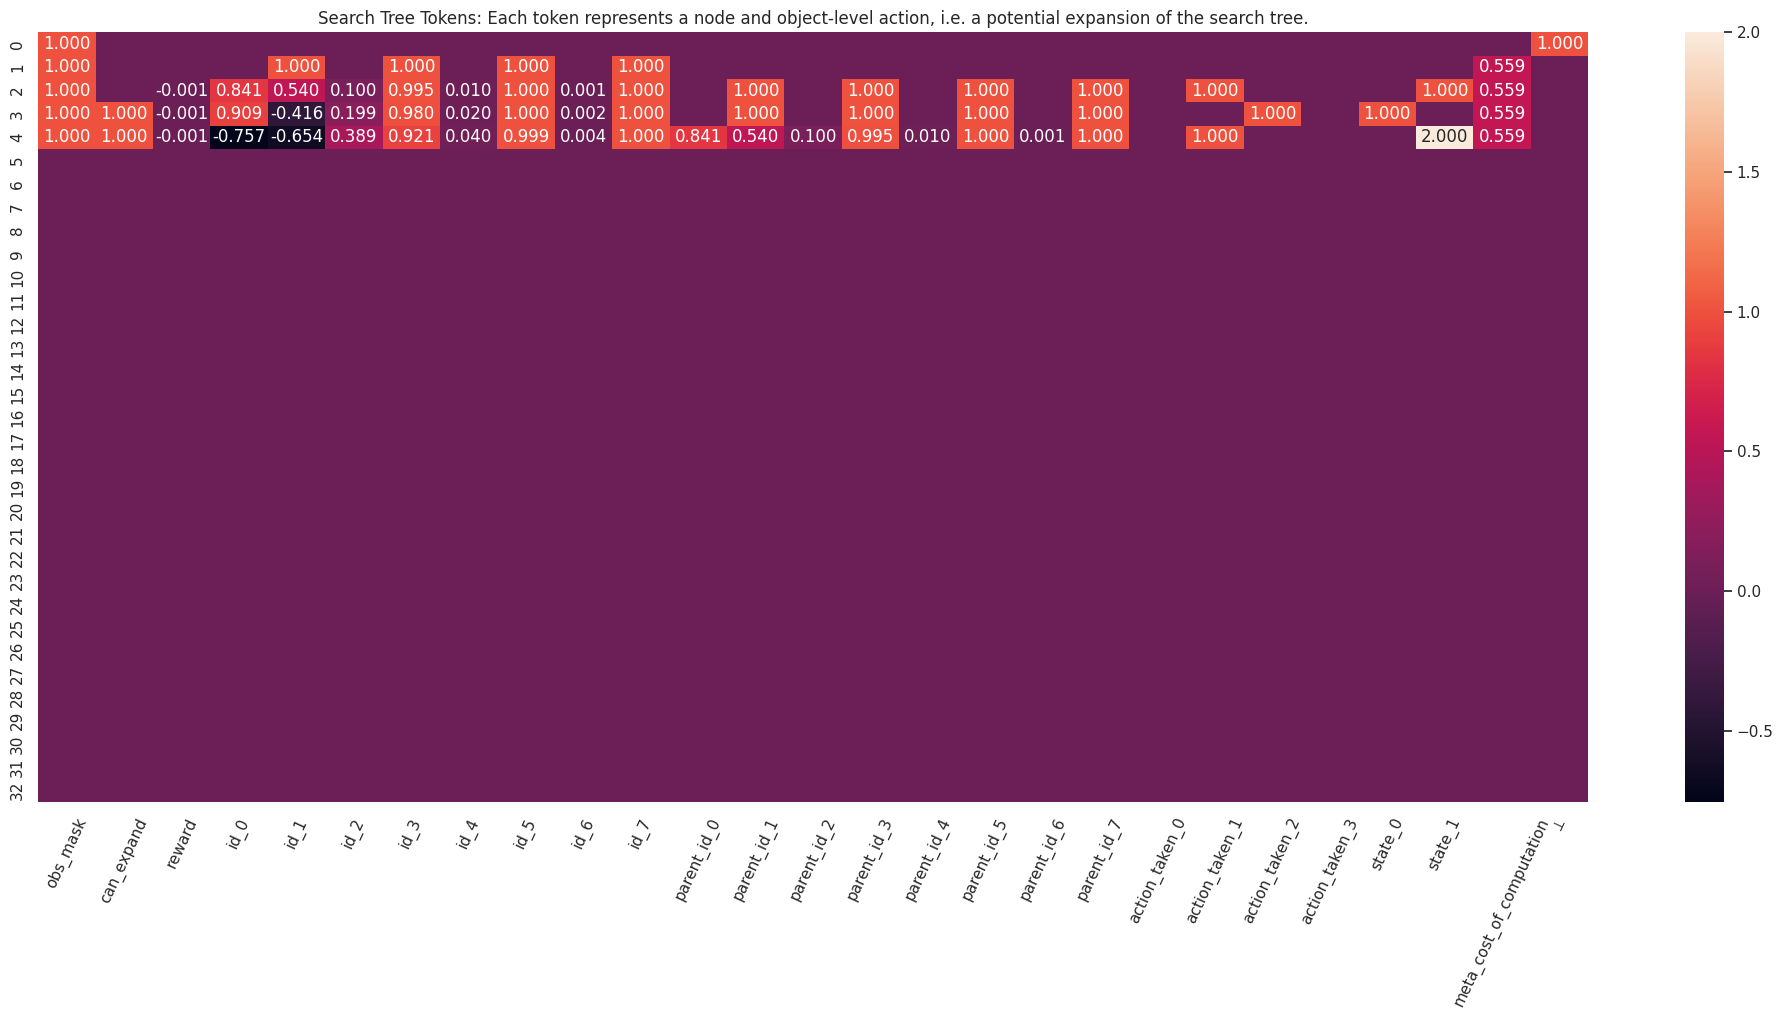

In [18]:
meta_env.plot_search_tokens()

In [12]:
a_star_results_df = pd.DataFrame(a_star_results)

In [6]:
# sparkling_horse_dir = 'outputs/runs/ppo_run_43-09-14-05-02-2023/'
# loaded_policy_dir = 'outputs/runs/ppo_run_55-47-14-06-02-2023/'
loaded_policy_dir = 'outputs/runs/ppo_run_55-01-17-13-02-2023/'
loaded_policy = tf.saved_model.load(loaded_policy_dir + 'policies/policy')

In [7]:
loaded_policy_results = compute_metrics_for_costs(
    make_policy=lambda env: loaded_policy,
    convert_to_eager=False)

NameError: name 'compute_metrics_for_costs' is not defined

In [12]:
loaded_policy_df = pd.DataFrame(loaded_policy_results)

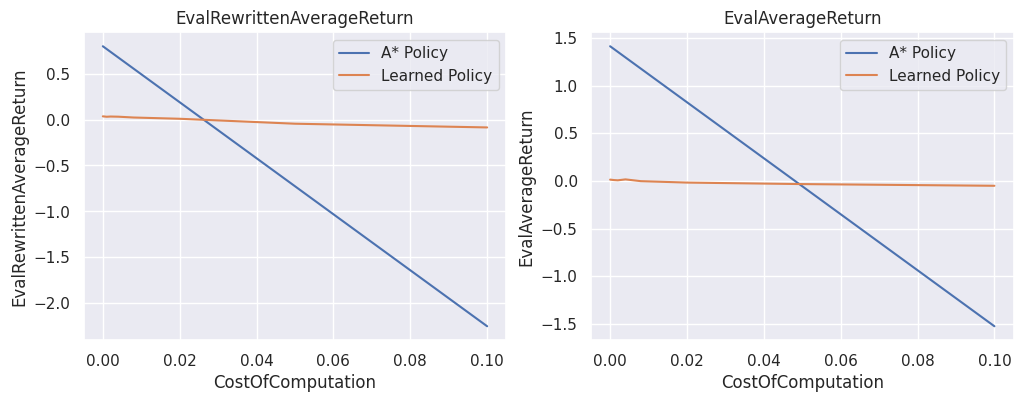

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, label in enumerate(['EvalRewrittenAverageReturn', 'EvalAverageReturn']):
    axs[i].set_title(label)
    plot = sns.lineplot(data=a_star_results_df,
                x='CostOfComputation', y=label,
                ax=axs[i], label='A* Policy')
    plot = sns.lineplot(data=loaded_policy_df,
                x='CostOfComputation', y=label,
                ax=axs[i], label='Learned Policy')
    # plot.set(xscale='log')
plt.show()

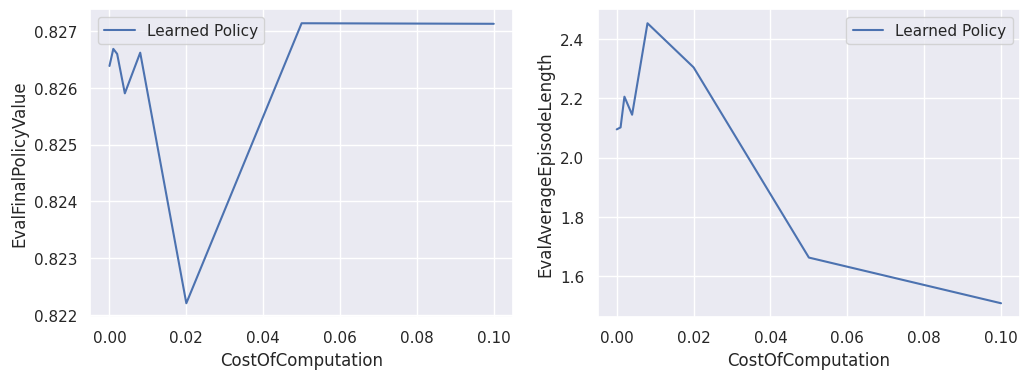

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, label in enumerate(['EvalFinalPolicyValue', 'EvalAverageEpisodeLength']):
    # axs[i].set_title(label)
    # plot = sns.lineplot(data=a_star_results_df,
    #             x='CostOfComputation', y=label,
    #             ax=axs[i], label='A* Policy')
    plot = sns.lineplot(data=loaded_policy_df,
                x='CostOfComputation', y=label, 
                ax=axs[i], label='Learned Policy')
    # plot.set(xscale='log')
plt.show()

In [8]:
@np.vectorize
def has_found_goal(meta_env) -> bool:
    goal = meta_env.object_env.env.maze_view.goal
    for node in meta_env.tree.node_list:
        if (node.state.get_state_vector() == goal).all():
            return True
    return False

In [9]:
from mlrl.experiments.experiment_utils import create_parser
from mlrl.experiments.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.experiments.ppo_maze import create_maze_meta_env


def compute_metrics_for_costs_no_terminate(
        make_policy=None, config=None,
        steps=500, batch_size=4,
        **eval_kwargs):
    costs = [
        0, 0.001, 0.002, 0.004, 0.008, 0.02, 0.05, 0.1
    ]
    # costs = [
    #     0, 0.001,
    # ]

    make_policy = make_policy or (lambda env: AStarPolicy(env))

    if config is None:
        parser = create_parser()
        config = vars(parser.parse_known_args()[0])

    config['random_cost_of_computation'] = False
    config['enable_rendering'] = False
    config['min_computation_steps'] = 1000
    # config['max_tree_size'] = 128
    config['maze_size'] = 5
    
    if 'seed' in config:
        del config['seed']

    results = []
    for cost in costs:
        print(f'Evaluating with computational cost = {cost}')

        config['cost_of_computation'] = cost
        envs = BatchedPyEnvironment([
            GymWrapper(create_maze_meta_env(seed=seed, **config))
            for seed in range(batch_size)
        ], multithreading=True)
        envs.reset()

        logs = dict()
        return_sum = np.zeros(batch_size)
        ep_counts = np.zeros(batch_size)
        found_goal_counts = np.zeros(batch_size)
        policy = make_policy(envs)

        for step in range(steps):
            policy_step = policy.action(envs.current_time_step())
            action = policy_step.action.numpy()
            found_goal = has_found_goal(envs.envs)
            action[found_goal] = 0
            _, reward, done, info = envs.step(action)
            return_sum += reward
            ep_counts += 1 - np.int32(done)  # seems that 0 is done
            found_goal_counts += np.int32(found_goal)

        logs['MeanReturn'] = np.mean(return_sum / ep_counts)
        logs['NumEpisodes'] = np.sum(ep_counts)
        logs['MeanEpisodeLength'] = steps * batch_size / np.sum(ep_counts)
        logs['FoundGoalCount'] = np.sum(found_goal_counts)
        print(', '.join(f'{k} = {v:.3f}' for k, v in logs.items()))
        results.append({'CostOfComputation': cost, **logs})
    
    return results

In [10]:
loaded_policy_results = compute_metrics_for_costs_no_terminate(lambda env: loaded_policy)
loaded_policy_df = pd.DataFrame(loaded_policy_results)

Evaluating with computational cost = 0
MeanReturn = 1.067, NumEpisodes = 97.000, MeanEpisodeLength = 20.619, FoundGoalCount = 191.000
Evaluating with computational cost = 0.001
MeanReturn = 1.063, NumEpisodes = 96.000, MeanEpisodeLength = 20.833, FoundGoalCount = 183.000
Evaluating with computational cost = 0.002
MeanReturn = 1.036, NumEpisodes = 96.000, MeanEpisodeLength = 20.833, FoundGoalCount = 190.000
Evaluating with computational cost = 0.004
MeanReturn = 1.047, NumEpisodes = 97.000, MeanEpisodeLength = 20.619, FoundGoalCount = 191.000
Evaluating with computational cost = 0.008
MeanReturn = 0.988, NumEpisodes = 94.000, MeanEpisodeLength = 21.277, FoundGoalCount = 184.000
Evaluating with computational cost = 0.02
MeanReturn = 0.636, NumEpisodes = 96.000, MeanEpisodeLength = 20.833, FoundGoalCount = 188.000
Evaluating with computational cost = 0.05
MeanReturn = 0.142, NumEpisodes = 99.000, MeanEpisodeLength = 20.202, FoundGoalCount = 196.000
Evaluating with computational cost = 0.1

In [11]:
a_star_results = compute_metrics_for_costs_no_terminate(steps=150)  # A* policy is deterministic so we don't need to run as many steps
a_star_results_df = pd.DataFrame(a_star_results)

Evaluating with computational cost = 0
MeanReturn = 1.019, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.001
MeanReturn = 1.001, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.002
MeanReturn = 0.983, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.004
MeanReturn = 0.947, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.008
MeanReturn = 0.875, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.02
MeanReturn = 0.659, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cost = 0.05
MeanReturn = 0.119, NumEpisodes = 100.000, MeanEpisodeLength = 20.000, FoundGoalCount = 200.000
Evaluating with computational cos

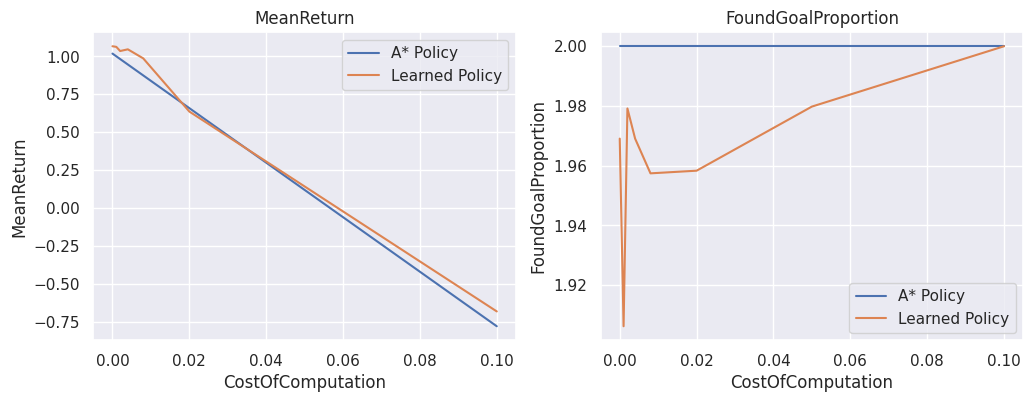

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

a_star_results_df['FoundGoalProportion'] = a_star_results_df['FoundGoalCount'] / a_star_results_df['NumEpisodes']
loaded_policy_df['FoundGoalProportion'] = loaded_policy_df['FoundGoalCount'] / loaded_policy_df['NumEpisodes']

for i, label in enumerate(['MeanReturn', 'FoundGoalProportion']):
    axs[i].set_title(label)
    plot = sns.lineplot(data=a_star_results_df,
                x='CostOfComputation', y=label,
                ax=axs[i], label='A* Policy')
    plot = sns.lineplot(data=loaded_policy_df,
                x='CostOfComputation', y=label,
                ax=axs[i], label='Learned Policy')
plt.show()

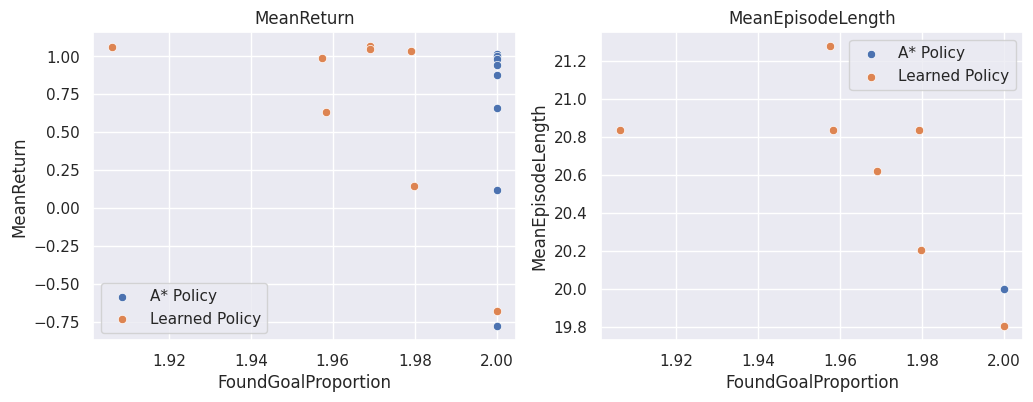

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i, label in enumerate(['MeanReturn', 'MeanEpisodeLength']):
    axs[i].set_title(label)
    plot = sns.scatterplot(data=a_star_results_df,
                x='FoundGoalProportion', y=label,
                ax=axs[i], label='A* Policy')
    plot = sns.scatterplot(data=loaded_policy_df,
                x='FoundGoalProportion', y=label,
                ax=axs[i], label='Learned Policy')
    # plot.set(xscale='log')
plt.show()

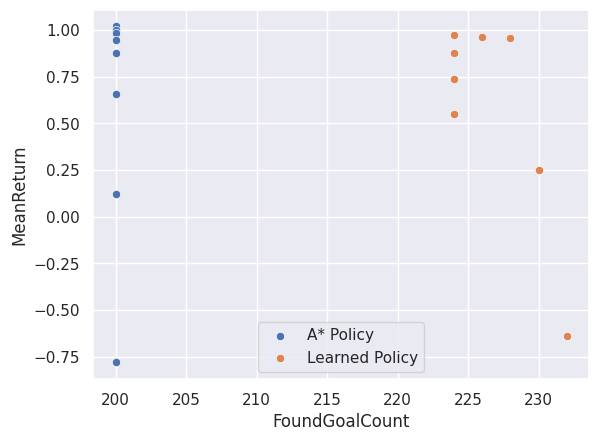

In [188]:
fig, ax = plt.subplots()

sns.scatterplot(data=a_star_results_df,
            x='FoundGoalCount',
            y='MeanReturn',
            label='A* Policy',
            ax=ax)
sns.scatterplot(data=loaded_policy_df,
            x='FoundGoalCount',
            y='MeanReturn',
            label='Learned Policy',
            ax=ax)
plt.show()

In [52]:
from mlrl.experiments.experiment_utils import create_parser
from mlrl.experiments.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.experiments.ppo_maze import create_maze_meta_env


def compute_metrics_for_costs(make_policy=None, **eval_kwargs):
    costs = [
        0, 0.001, 0.002, 0.004, 0.008, 0.02, 0.05, 0.1
    ]

    make_policy = make_policy or (lambda env: AStarPolicy(env))

    parser = create_parser()
    config = vars(parser.parse_known_args()[0])

    BATCH_SIZE = 4
    STEPS = 150

    config['random_cost_of_computation'] = False
    config['enable_rendering'] = False
    
    if 'seed' in config:
        del config['seed']

    results = []
    for cost in costs:
        print(f'Evaluating with computational cost = {cost}')

        config['cost_of_computation'] = cost
        envs = BatchedPyEnvironment([
            GymWrapper(create_maze_meta_env(seed=seed, **config))
            for seed in range(BATCH_SIZE)
        ], multithreading=True)
        envs.reset()

        logs = dict()
        return_sum = np.zeros(BATCH_SIZE)
        ep_counts = np.zeros(BATCH_SIZE)
        policy = make_policy(envs)

        for step in range(STEPS):
            policy_step = policy.action(envs.current_time_step())
            next_obs, reward, done, info = envs.step(policy_step.action)
            return_sum += reward
            # return_sum[done] = 0
            ep_counts += np.int32(done)

        logs['MeanReturn'] = np.mean(return_sum / ep_counts)
        print(', '.join(f'{k} = {v:.3f}' for k, v in logs.items()))
        results.append({'CostOfComputation': cost, **logs})
        # evaluator = EvalRunner(
        #     eval_steps=envs.batch_size * STEPS,
        #     eval_env=envs,
        #     policy=make_policy(envs),
        #     rewrite_rewards=True,
        #     **eval_kwargs)
        
        # results.append({'CostOfComputation': cost, **evaluator.run()})
    
    return results

In [55]:
parser = create_parser()
config = vars(parser.parse_known_args()[0])

BATCH_SIZE = 4
STEPS = 150

config['random_cost_of_computation'] = False
config['enable_rendering'] = False

if 'seed' in config:
    del config['seed']

envs = BatchedPyEnvironment([
    GymWrapper(create_maze_meta_env(seed=seed, **config))
    for seed in range(BATCH_SIZE)
], multithreading=True)

In [58]:
np.array(envs.envs)[np.array([True, False, True, False])]

array([<tf_agents.environments.gym_wrapper.GymWrapper object at 0x7f6f6735d2a0>,
      dtype=object)

In [54]:
compute_metrics_for_costs(
    make_policy=lambda env: sparkling_horse_policy,
    convert_to_eager=False)

Evaluating with computational cost = 0
Evaluating with computational cost = 0.001
Evaluating with computational cost = 0.002
Evaluating with computational cost = 0.004
Evaluating with computational cost = 0.008
Evaluating with computational cost = 0.02
Evaluating with computational cost = 0.05
Evaluating with computational cost = 0.1


[{'CostOfComputation': 0, 'MeanReturn': 0.009196658912725801},
 {'CostOfComputation': 0.001, 'MeanReturn': 0.0019766167787634435},
 {'CostOfComputation': 0.002, 'MeanReturn': 0.011784940654902218},
 {'CostOfComputation': 0.004, 'MeanReturn': 0.002092399828265568},
 {'CostOfComputation': 0.008, 'MeanReturn': -0.0003757476635156431},
 {'CostOfComputation': 0.02, 'MeanReturn': 0.000524318603800278},
 {'CostOfComputation': 0.05, 'MeanReturn': -0.0209903646547885},
 {'CostOfComputation': 0.1, 'MeanReturn': -0.029067959610552228}]

In [48]:
np.int32(np.array([False, True]))

array([0, 1], dtype=int32)

In [17]:
env, eval_env, video_env = create_batched_maze_meta_envs(**{**args, **{'maze_size': 10}})

In [19]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(AStarPolicy(video_env), video_env, max_steps=60, rewrite_rewards=True))

In [16]:
from mlrl.utils.render_utils import create_and_save_policy_eval_video, embed_mp4
embed_mp4(create_and_save_policy_eval_video(ppo_runner.collect_policy, ppo_runner.video_env, max_steps=30, rewrite_rewards=True))